# Banana Navigation Solution

## 1. Set up the environment

In [1]:
from agent import Agent

from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from unityagents import UnityEnvironment

We start by starting the environment. The exact path and file we need to run will vary. Adjust the next cell accordingly.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

The code cell below prints basic information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 2. Train the agent using a DQN

Episode 100	Average Score: 0.12
Episode 200	Average Score: 2.37
Episode 300	Average Score: 7.25
Episode 400	Average Score: 9.29
Episode 500	Average Score: 11.99
Episode 561	Average Score: 13.00
Environment solved in 461 episodes!	Average Score: 13.00


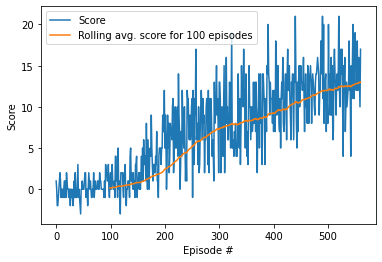

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, seed=666)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        beta_start=0.1, beta_end=1.0, beta_ascend=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        beta_start (float): starting value for the power factor used for importance weights
        beta_end (float): maximum value for the power factor
        beta_ascend (float): multiplicative factor (per episode) for increasing beta
    """
    scores = []                                                  # list containing scores from each episode
    scores_window = deque(maxlen=100)                            # last 100 scores
    eps = eps_start                                              # initialize epsilon
    beta = beta_start                                            # initialize beta
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
        state = env_info.vector_observations[0]                  # get the initial state
        score = 0                                                # initialize the score
        for t in range(max_t):                                   # loop over steps in an episode
            action = agent.act(state, eps)                       # select an action
            env_info = env.step(action)[brain_name]              # send the action to the environment
            next_state = env_info.vector_observations[0]         # get the next state
            reward = env_info.rewards[0]                         # get the reward
            done = env_info.local_done[0]                        # see if episode has finished
            agent.step(state, action, reward, next_state, done,  # next agent step
                       beta)  
            score += reward                                      # update the score
            state = next_state                                   # roll over the state to next time step
            if done:                                             # end of the episode
                break 
        scores_window.append(score)                              # save most recent score
        scores.append(score)                                     # save most recent score
        eps = max(eps_end, eps_decay * eps)                      # decrease epsilon
        beta = min(beta_end, beta / beta_ascend)                 # increase beta
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end='')
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

# get the scores
scores = dqn()

# plot the scores
scores_df = pd.DataFrame({'scores': scores})
scores_df['rolling_avg_score'] = scores_df.scores.rolling(100).mean()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores_df.index, scores_df['scores'])
plt.plot(scores_df.index, scores_df['rolling_avg_score'])
ax.legend(['Score', 'Rolling avg. score for 100 episodes'])
plt.ylabel('Score')
plt.xlabel('Episode #')
fig.patch.set_facecolor('lightgrey')
plt.show()

## 3. Observe a trained agent

In [13]:
# initialize the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# load trained agent weights
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

n_episodes = 5
scores = []
for i_episode in range(n_episodes):
    env_info = env.reset(train_mode=False)[brain_name]   # reset the environment
    state = env_info.vector_observations[0]              # get the current state
    score = 0                                            # initialize the score
    while True:
        action = agent.act(state, eps=0)                 # select an action
        env_info = env.step(action)[brain_name]          # send the action to the environment
        next_state = env_info.vector_observations[0]     # get the next state
        reward = env_info.rewards[0]                     # get the reward
        done = env_info.local_done[0]                    # see if episode has finished
        score += reward                                  # update the score
        state = next_state                               # roll over the state to next time step
        if done:                                         # exit loop if episode finished
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode + 1, score))
            scores.append(score)
            break

Episode 1	Average Score: 13.00
Episode 2	Average Score: 14.00
Episode 3	Average Score: 19.00
Episode 4	Average Score: 18.00
Episode 5	Average Score: 20.00


In [14]:
env.close()